In [1]:
MODEL_PATH      = "SAM_models/sam_vit_b_01ec64.pth"
IMAGE_PATH      = "Images/Original_Img.jpg"
STROKES_PATH    = "Images/Strokes.json" 
TREND_PATH      = "Images/Trend.jpg"
SAM_PATH        = "Images/SAM_Img.jpg"
CNN_PATH        = "Images/CNN_Img.jpg"

from    segment_anything import sam_model_registry, SamAutomaticMaskGenerator
from    torchvision.transforms import functional as F
from    skimage.measure import label
from    matplotlib.patches import Patch

import  numpy as np
import  matplotlib.pyplot as plt
import  pandas as pd
import  cv2
import  torch
import  torchvision
import  json
import  csv
import  os

In [ ]:
# Step 1: Full image automatic masks detection

# Load and prepare an image - BGR to RGB
image = cv2.imread(IMAGE_PATH)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

C:\Users\Hoan\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Hoan\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# SAM
# Load SAM Model - using the ViT-B SAM model 
DEVICE = "cpu" 
sam    = sam_model_registry["vit_b"](checkpoint=MODEL_PATH).to(DEVICE)

# Create an automatic mask generator 
mask_generator = SamAutomaticMaskGenerator(
    sam,
    points_per_side         = 16,  
    pred_iou_thresh         = 0.85, 
    stability_score_thresh  = 0.9,
    min_mask_region_area    = 1000
)

# Generate masks
SAM_masks = mask_generator.generate(image)

In [ ]:
# CNN
# Load Mask R-CNN Model
image_tensor    = F.to_tensor(image).unsqueeze(0)  # shape: [1, 3, H, W]
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
model.eval()

# Inference
with torch.no_grad():
    prediction = model(image_tensor)[0]
    
# Generate masks
CNN_masks = prediction['masks'].cpu().numpy() 

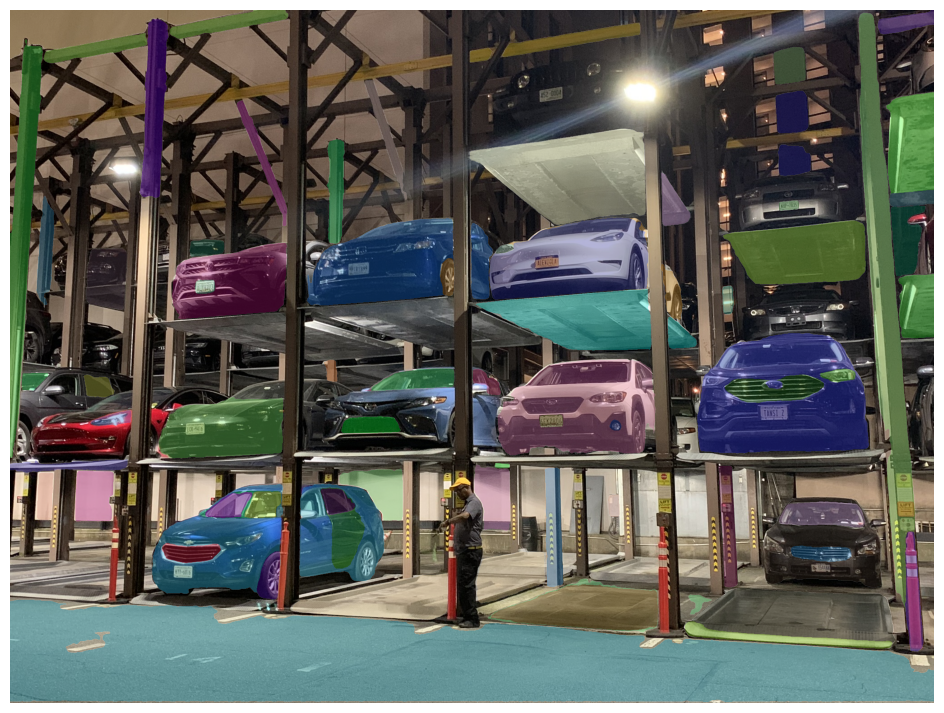

In [3]:
# SAM interpretation
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax          = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m           = ann['segmentation']
        color_mask  = np.concatenate([np.random.random(3), [0.35]])
        img[m]      = color_mask
    ax.imshow(img)

plt.figure(figsize=(12, 9))
plt.imshow(image)
show_anns(SAM_masks)
plt.axis("off")
plt.show()


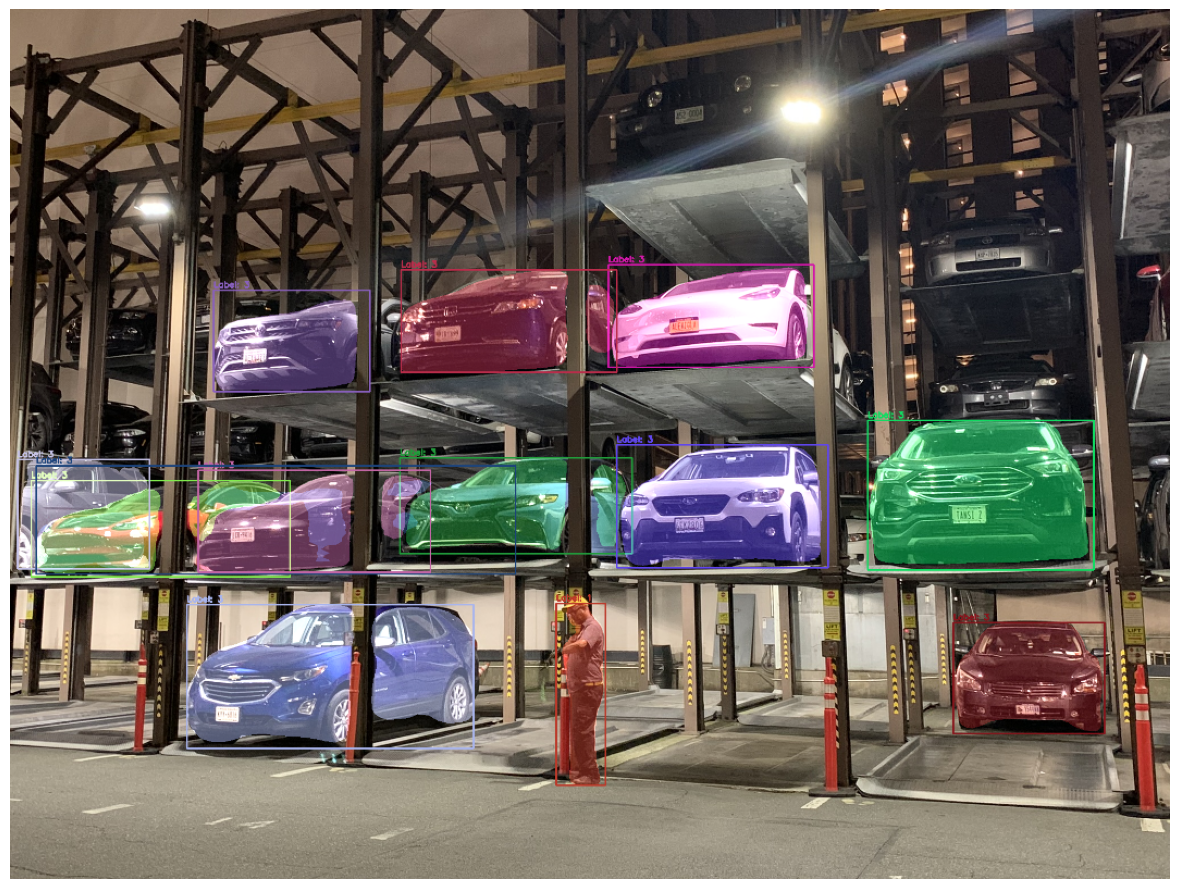

In [4]:
# Mask R-CNN interpretation
visual_image = image.copy()

# Loop through predictions
for i in range(len(prediction['boxes'])):
    if prediction['scores'][i] < 0.7:
        continue

    # Extract bounding box, label, and mask
    box = prediction['boxes'][i].cpu().numpy().astype(int)
    label_id = prediction['labels'][i].item()
    mask = (prediction['masks'][i, 0].cpu().numpy() > 0.5).astype(np.uint8)

    # Random color for mask and box
    color = np.random.randint(0, 255, (3,), dtype=int).tolist()

    # Apply colored mask
    colored_mask = np.stack([mask * c for c in color], axis=-1)
    visual_image = cv2.addWeighted(visual_image, 1.0, colored_mask, 0.5, 0)

    # Draw bounding box and label
    cv2.rectangle(visual_image, (box[0], box[1]), (box[2], box[3]), color, 2)
    cv2.putText(visual_image, f"Label: {label_id}", (box[0], box[1] - 5),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

# Resize for display
max_height  = 800
scale       = max_height / visual_image.shape[0]
resized     = cv2.resize(visual_image, (int(visual_image.shape[1] * scale), max_height))

# Show with matplotlib
plt.figure(figsize=(12, 9))
plt.imshow(resized )
plt.axis("off")
plt.tight_layout()
plt.show()



In [5]:
# Step 2: User mask-processing
img_height, img_width   = image.shape[:2]

print(f"[INFO] Loaded image: {IMAGE_PATH}")
print(f"[INFO] Image size: height={img_height}, width={img_width}")

# Prepare blank mask
user_mask = np.zeros((img_height, img_width), dtype=np.uint8)

# Load strokes
with open(STROKES_PATH, "r") as f:
    strokes_data = json.load(f)

# Draw strokes on mask
for stroke in strokes_data:
    points = np.array([[int(p["x"]), int(p["y"])] for p in stroke["points"]], dtype=np.int32)
    points = points.reshape((-1, 1, 2))
    cv2.fillPoly(user_mask, [points], color=1)

# Optionally fill
user_mask = cv2.dilate(user_mask, np.ones((3, 3), np.uint8), iterations=1)
user_mask = cv2.morphologyEx(user_mask, cv2.MORPH_CLOSE, np.ones((5, 5), np.uint8))
user_mask = (user_mask > 0).astype(np.uint8)

print(f"[INFO] User mask size: {user_mask.shape}")
print(f"[INFO] User mask non-zero pixels: {np.count_nonzero(user_mask)}")

[INFO] Loaded image: Images/Original_Img.jpg
[INFO] Image size: height=1536, width=2048
[INFO] User mask size: (1536, 2048)
[INFO] User mask non-zero pixels: 171959


In [6]:
def compute_iou(mask1, mask2):
    intersection = np.logical_and(mask1, mask2).sum()
    union = np.logical_or(mask1, mask2).sum()
    return intersection / union if union > 0 else 0.0

In [7]:
# Step 3: Masks Comparision

USER_combined_mask  = np.zeros_like(user_mask)
user_labeled        = label(user_mask)
num_regions         = np.max(user_labeled)
USER_binary_masks   = [(user_labeled == i).astype(np.uint8) for i in range(1, num_regions + 1)]
print(f"[INFO] Found {num_regions} user-defined regions.")

CNN_masks           = prediction['masks'].cpu().numpy() 
CNN_combined_mask   = np.zeros_like(user_mask)
CNN_masks           = CNN_masks[:, 0] 
CNN_binary_masks    = (CNN_masks > 0.5).astype(np.uint8)  

SAM_combined_mask   = np.zeros_like(user_mask)
SAM_binary_masks    = [m["segmentation"].astype(np.uint8) for m in SAM_masks]

def Compare_Masks(USER_binary_masks, AUTO_binary_masks, USER_combined_mask, AUTO_combined_mask):
    ious    = []
    for i, u_mask in enumerate(USER_binary_masks):
        best_iou = 0
        best_idx = -1
        for j, b_mask in enumerate(AUTO_binary_masks):
            if b_mask.shape != u_mask.shape:
                b_mask = cv2.resize(b_mask, (u_mask.shape[1], u_mask.shape[0]), interpolation=cv2.INTER_NEAREST)

            iou = compute_iou(u_mask, b_mask)
            if iou > best_iou:
                best_iou = iou
                best_idx = j

        if best_idx == -1:
            print(f"[WARN] No matching mask found for user region {i}")
            continue

        best_masks          = AUTO_binary_masks[best_idx]
        USER_combined_mask  = np.logical_or(USER_combined_mask, u_mask)
        AUTO_combined_mask  = np.logical_or(AUTO_combined_mask, best_masks)
        ious.append(best_iou)

    avg_iou = sum(ious) / len(ious) if ious else 0
    return USER_combined_mask, AUTO_combined_mask, avg_iou

SAM_USER_combined_mask, SAM_combined_mask, SAM_avg_iou = Compare_Masks(USER_binary_masks, SAM_binary_masks, USER_combined_mask, SAM_combined_mask)
CNN_USER_combined_mask, CNN_combined_mask, CNN_avg_iou = Compare_Masks(USER_binary_masks, CNN_binary_masks, USER_combined_mask, CNN_combined_mask)
SC_iou = compute_iou(SAM_combined_mask, CNN_combined_mask)

print(f"[INFO] Average SAM IoU: {SAM_avg_iou:.4f}")
print(f"[INFO] Average CNN IoU: {CNN_avg_iou:.4f}")
print(f"[INFO] SAM vs CNN IoU: {SC_iou:.4f}")


[INFO] Found 2 user-defined regions.
[INFO] Average SAM IoU: 0.4868
[INFO] Average CNN IoU: 0.7170
[INFO] SAM vs CNN IoU: 0.7082


In [8]:
# Save to the results to a file
csv_file        = "iou_results.csv"
write_header    = not os.path.exists(csv_file)

with open(csv_file, "a", newline="") as f:
    writer = csv.writer(f)
    if write_header:
        writer.writerow(["SAM_avg_iou", "CNN_avg_iou", "SC_iou"])
    writer.writerow([SAM_avg_iou, CNN_avg_iou, SC_iou])

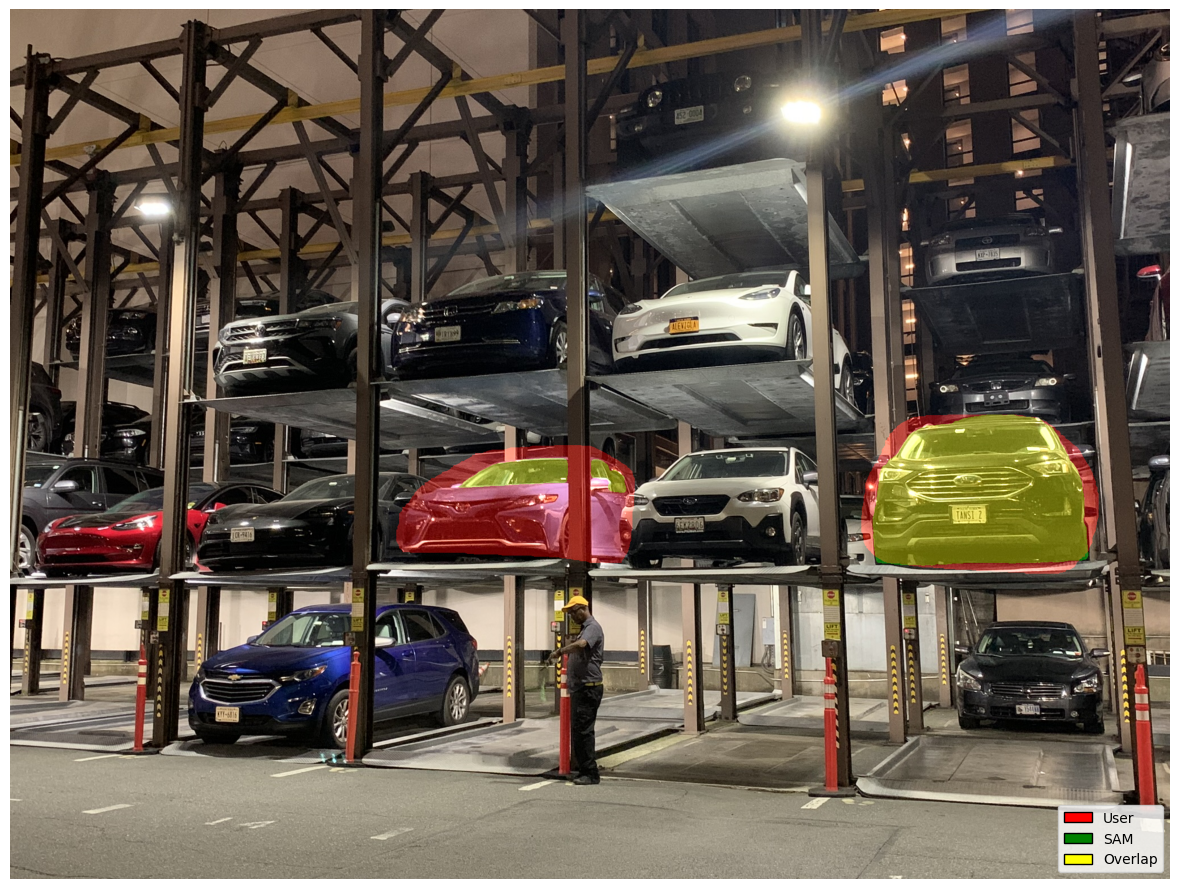

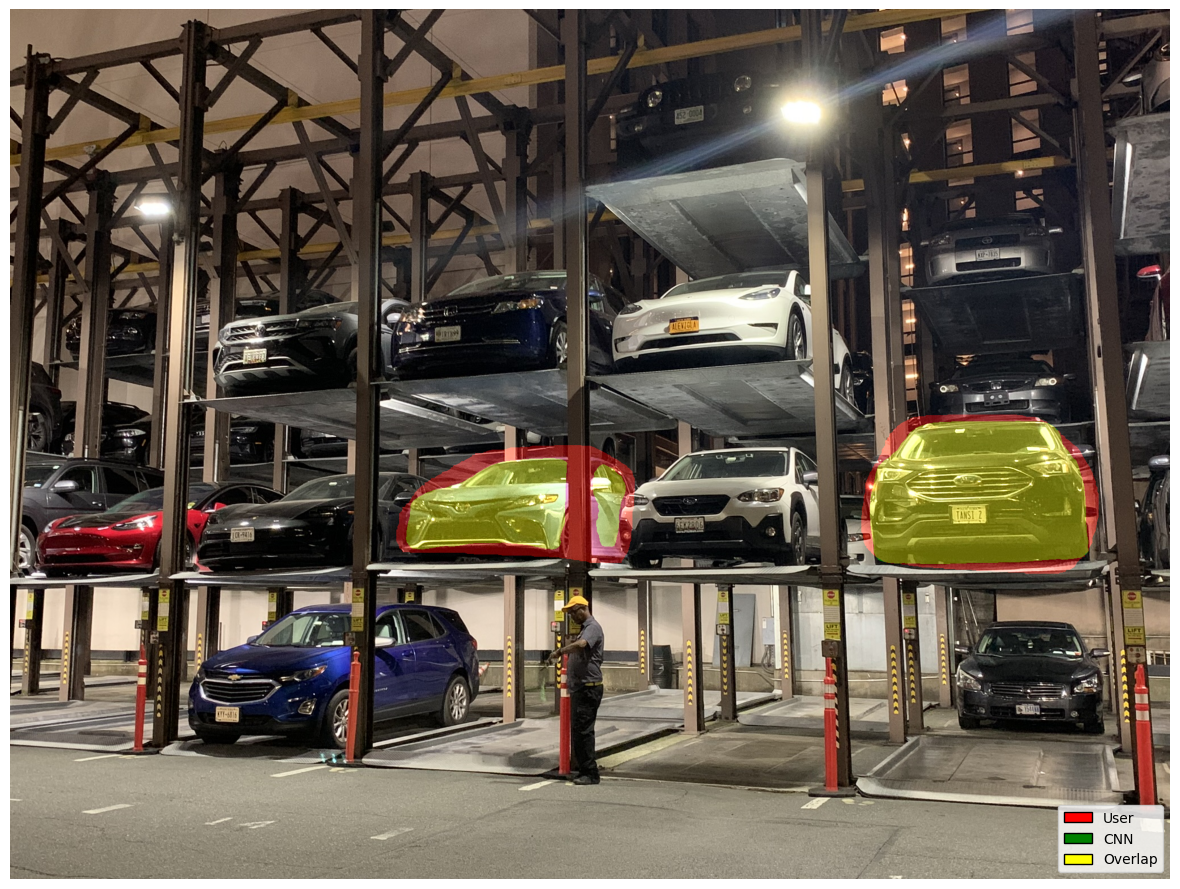

In [9]:
# Step 4: Create visualization
def Create_Vis(User_combined_mask, Auto_combined_mask, Image_Path, label_txt):
    # Red = user, Green = auto, Yellow = overlap
    user    = np.logical_and(User_combined_mask == 1, Auto_combined_mask == 0)
    auto    = np.logical_and(User_combined_mask == 0, Auto_combined_mask== 1)
    both    = np.logical_and(User_combined_mask == 1, Auto_combined_mask == 1)

    overlay_mask = np.zeros_like(image)
    overlay_mask[user]  = [255, 0, 0]     # Red
    overlay_mask[auto]  = [0, 255, 0]     # Green
    overlay_mask[both]  = [255, 255, 0]   # Yellow

    # Blend with original image
    alpha = 0.4
    final_overlay = cv2.addWeighted(image, 1.0, overlay_mask, alpha, 0)
    plt.figure(figsize=(12, 9))
    plt.imshow(final_overlay)
    plt.axis("off")

    # Add legend
    legend_elements = [
        Patch(facecolor='red',   edgecolor='black', label='User'),
        Patch(facecolor='green', edgecolor='black', label= label_txt),
        Patch(facecolor='yellow',edgecolor='black', label='Overlap'),
    ]
    plt.legend(handles=legend_elements, loc='lower right', fontsize=10)

    plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
    plt.tight_layout()
    plt.savefig(Image_Path, bbox_inches='tight', pad_inches=0)
    plt.show()

Create_Vis(SAM_USER_combined_mask, SAM_combined_mask, SAM_PATH, "SAM")
Create_Vis(CNN_USER_combined_mask, CNN_combined_mask, CNN_PATH, "CNN")

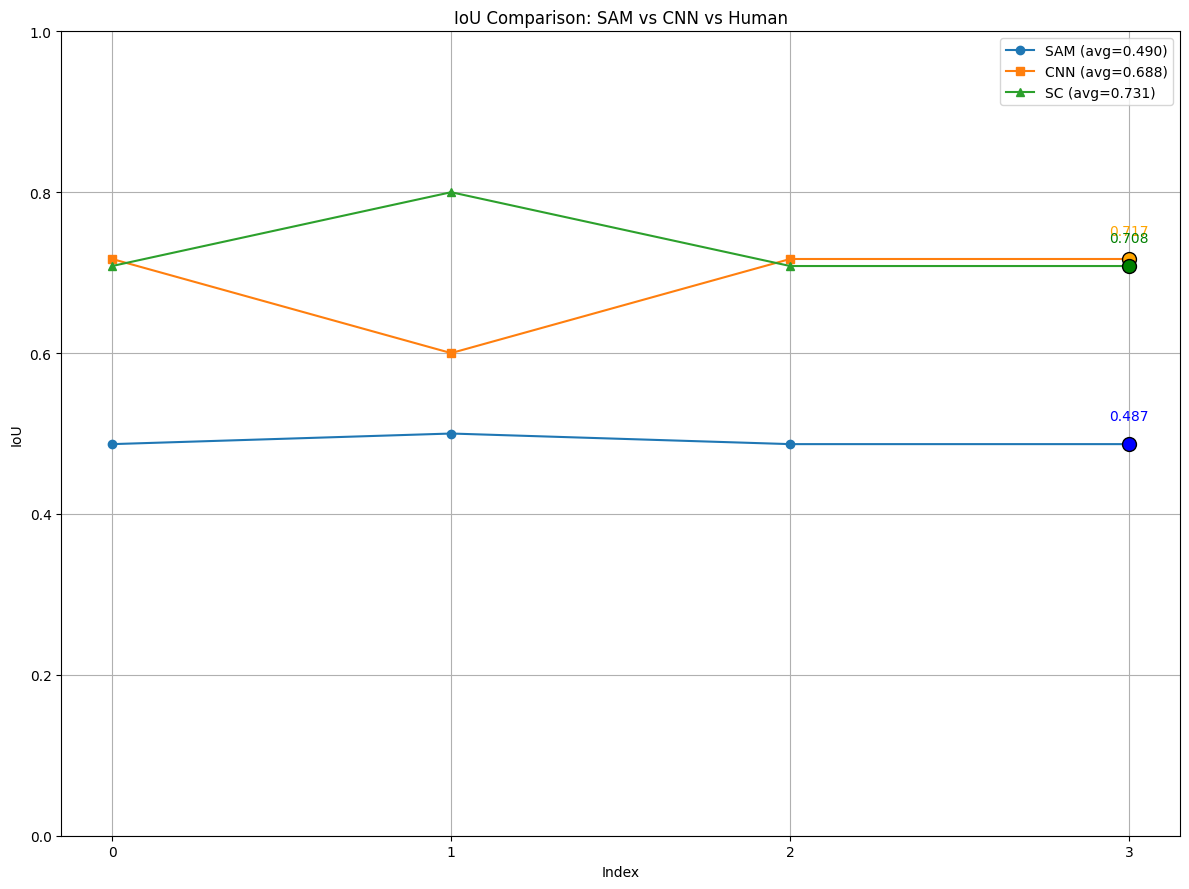

In [10]:
# Trend visualization
df = pd.read_csv("iou_results.csv")

# Compute averages
avg_sam = df["SAM_avg_iou"].mean()
avg_cnn = df["CNN_avg_iou"].mean()
avg_sc  = df["SC_iou"].mean()

# Plot
plt.figure(figsize=(12, 9))

# Plot full lines
plt.plot(df["SAM_avg_iou"], marker='o', label=f"SAM (avg={avg_sam:.3f})")
plt.plot(df["CNN_avg_iou"], marker='s', label=f"CNN (avg={avg_cnn:.3f})")
plt.plot(df["SC_iou"], marker='^', label=f"SC (avg={avg_sc:.3f})")


# Highlight last result
last_index = len(df) - 1
last_sam = df["SAM_avg_iou"].iloc[-1]
last_cnn = df["CNN_avg_iou"].iloc[-1]
last_sc = df["SC_iou"].iloc[-1]

plt.scatter(last_index, last_sam, color='blue', s=100, edgecolor='black', zorder=5)
plt.scatter(last_index, last_cnn, color='orange', s=100, edgecolor='black', zorder=5)
plt.scatter(last_index, last_sc, color='green', s=100, edgecolor='black', zorder=5)

# Annotate latest points
offset = 0.03
plt.text(last_index, last_sam + offset, f"{last_sam:.3f}", color='blue', ha='center')
plt.text(last_index, last_cnn + offset, f"{last_cnn:.3f}", color='orange', ha='center')
plt.text(last_index, last_sc + offset, f"{last_sc:.3f}", color='green', ha='center')

# Labels and styling
plt.title("IoU Comparison: SAM vs CNN vs Human")
plt.xlabel("Index")
plt.ylabel("IoU")
plt.ylim(0, 1)
plt.xticks(range(len(df)))
plt.grid(True)
plt.legend()
plt.tight_layout()

# Save and show
plt.savefig(TREND_PATH)
plt.show()

